In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from EDA import run_eda

In [3]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [4]:
data = pd.read_csv("../data_folder/raw_data/train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.00,0.85,0.56,1.00,-4.96,1,0.05,0.02,NaN,0.08,0.90,134.07,"234,596.00",4,5
1,Boston,Hitch a Ride,54.00,0.38,0.81,3.00,-7.23,1,0.04,0.00,0.00,0.10,0.57,116.45,"251,733.00",4,10
2,The Raincoats,No Side to Fall In,35.00,0.43,0.61,6.00,-8.33,1,0.05,0.49,0.00,0.39,0.79,147.68,"109,667.00",4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.00,0.85,0.60,10.00,-6.53,0,0.06,0.02,NaN,0.12,0.57,107.03,"173,968.00",4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.00,0.17,0.97,2.00,-4.28,1,0.22,0.00,0.02,0.17,0.09,199.06,"229,960.00",4,10


Сразу разобъём данные на `train` и `test`:

In [28]:
X, y = data.loc[:, :'time_signature'], data[['Class']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=SEED)

Все манипуляции будет проводить с `train`:

Hi there, fellow researcher.

Dataframe consists of 16 variables and 14396 observations

Following variables can be classified as string-type: ('Artist Name', 'Track Name')
Following variables can be classified as number-type: ('danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms')
Following variables can be classified as factor-type: ('Popularity', 'key', 'mode', 'time_signature')
Criteria are unique values count (lower than 100 is factor) and then data type ("int64"/"float64" is number, "object" is string).

1) Basic statistics for factor-type variables.

For variable "Popularity:
- Counts:
Popularity
42.00     374
41.00     366
44.00     345
34.00     342
43.00     332
37.00     331
45.00     327
38.00     327
46.00     319
36.00     306
40.00     306
35.00     305
50.00     293
32.00     287
47.00     285
49.00     284
53.00     279
39.00     277
33.00     274
48.00     274
51.00     272
54.00  

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms
count,"14,396.00","14,396.00","14,396.00","14,396.00","14,396.00","10,906.00","14,396.00","14,396.00","14,396.00","14,396.00"
mean,0.54,0.66,-7.89,0.08,0.25,0.18,0.20,0.49,122.65,"200,906.46"
std,0.17,0.23,4.02,0.08,0.31,0.30,0.16,0.24,29.70,"111,371.51"
min,0.06,0.00,-39.95,0.02,0.00,0.00,0.01,0.02,30.56,0.50
25%,0.43,0.51,-9.51,0.03,0.00,0.00,0.10,0.30,99.37,"166,899.75"
50%,0.55,0.70,-7.02,0.05,0.08,0.00,0.13,0.48,120.11,"209,445.00"
75%,0.66,0.86,-5.19,0.08,0.43,0.20,0.26,0.67,142.02,"252,533.25"
max,0.99,1.00,1.35,0.95,1.00,1.00,1.00,0.98,217.42,"1,477,187.00"
n_outliers,545.00,433.00,965.00,"1,678.00",887.00,"1,999.00",977.00,0.00,268.00,"3,095.00"
n_unique,895.00,"1,146.00","7,998.00","1,169.00","3,709.00","3,987.00","1,407.00","1,262.00","11,400.00","11,755.00"


Numeric variables visualization:


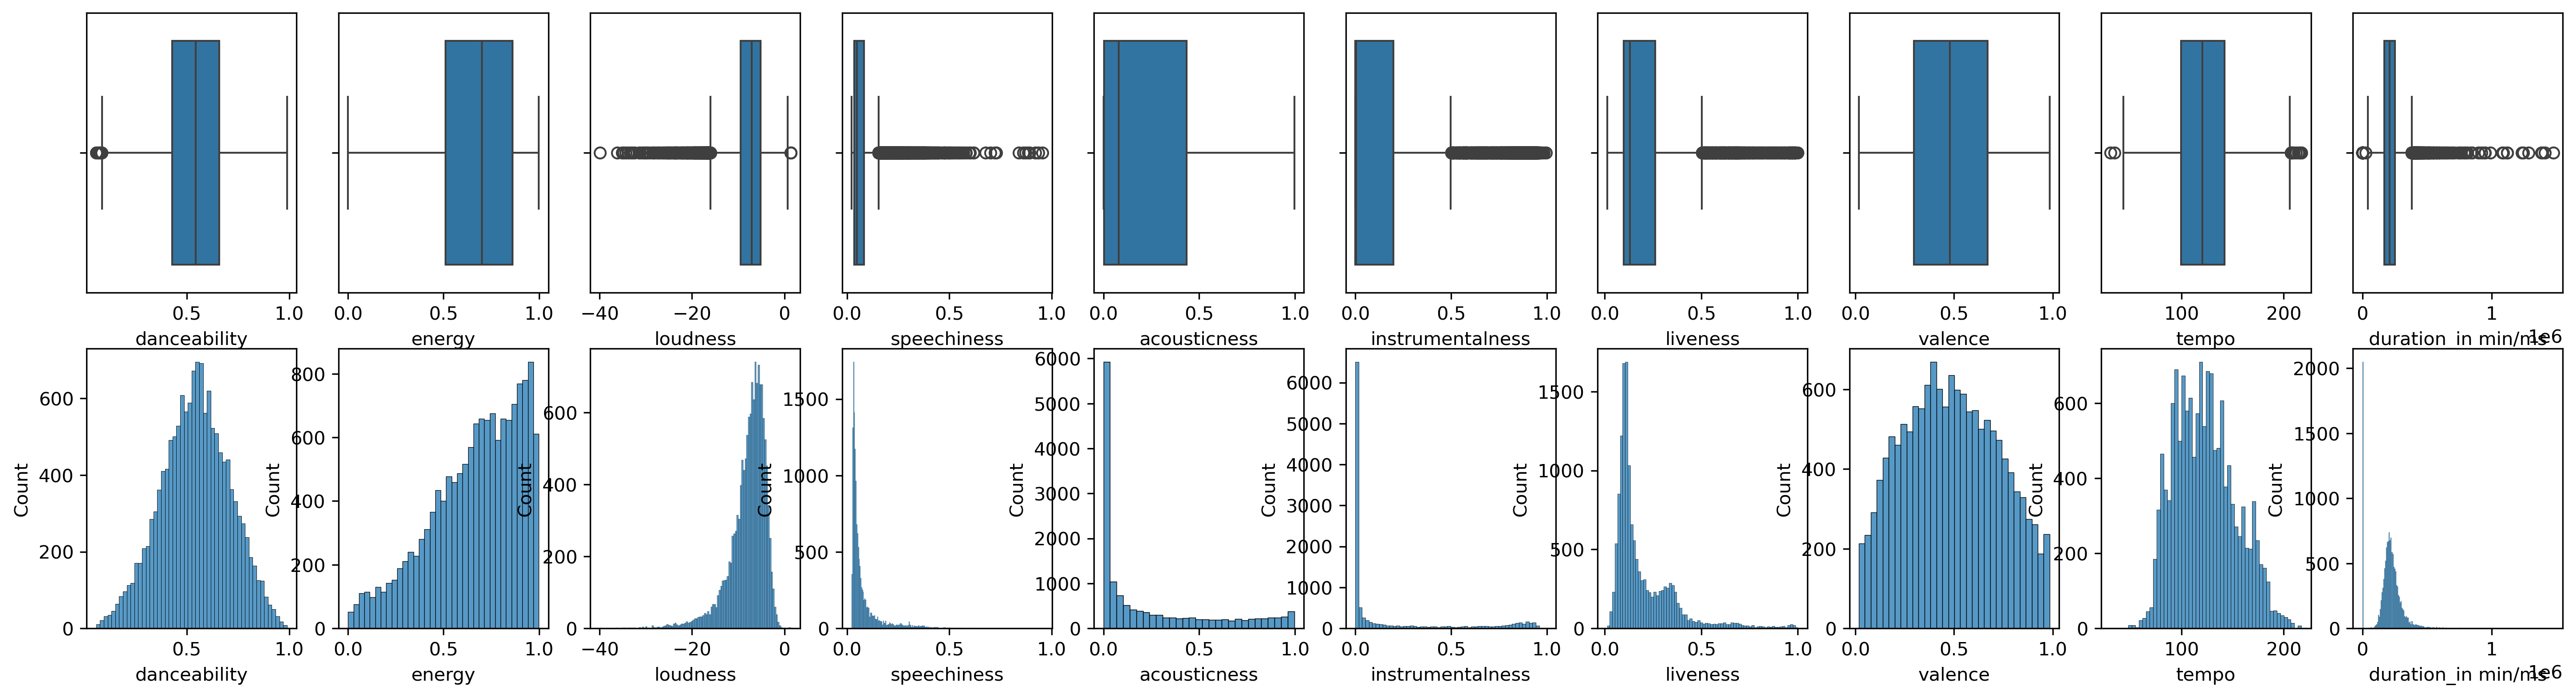

3) NA values:
- Total NA count is 5468 in 4942 rows.
- Following columns contain NA: ('Popularity', 'key', 'instrumentalness')

Dataframe contains 1069 duplicates.


d:\Users\d2707\Documents\Colab Notebooks\Курсы\Институт биоинформатики\Семестр 2\ML\BI_ML_2024\HW4_dt\code\EDA.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


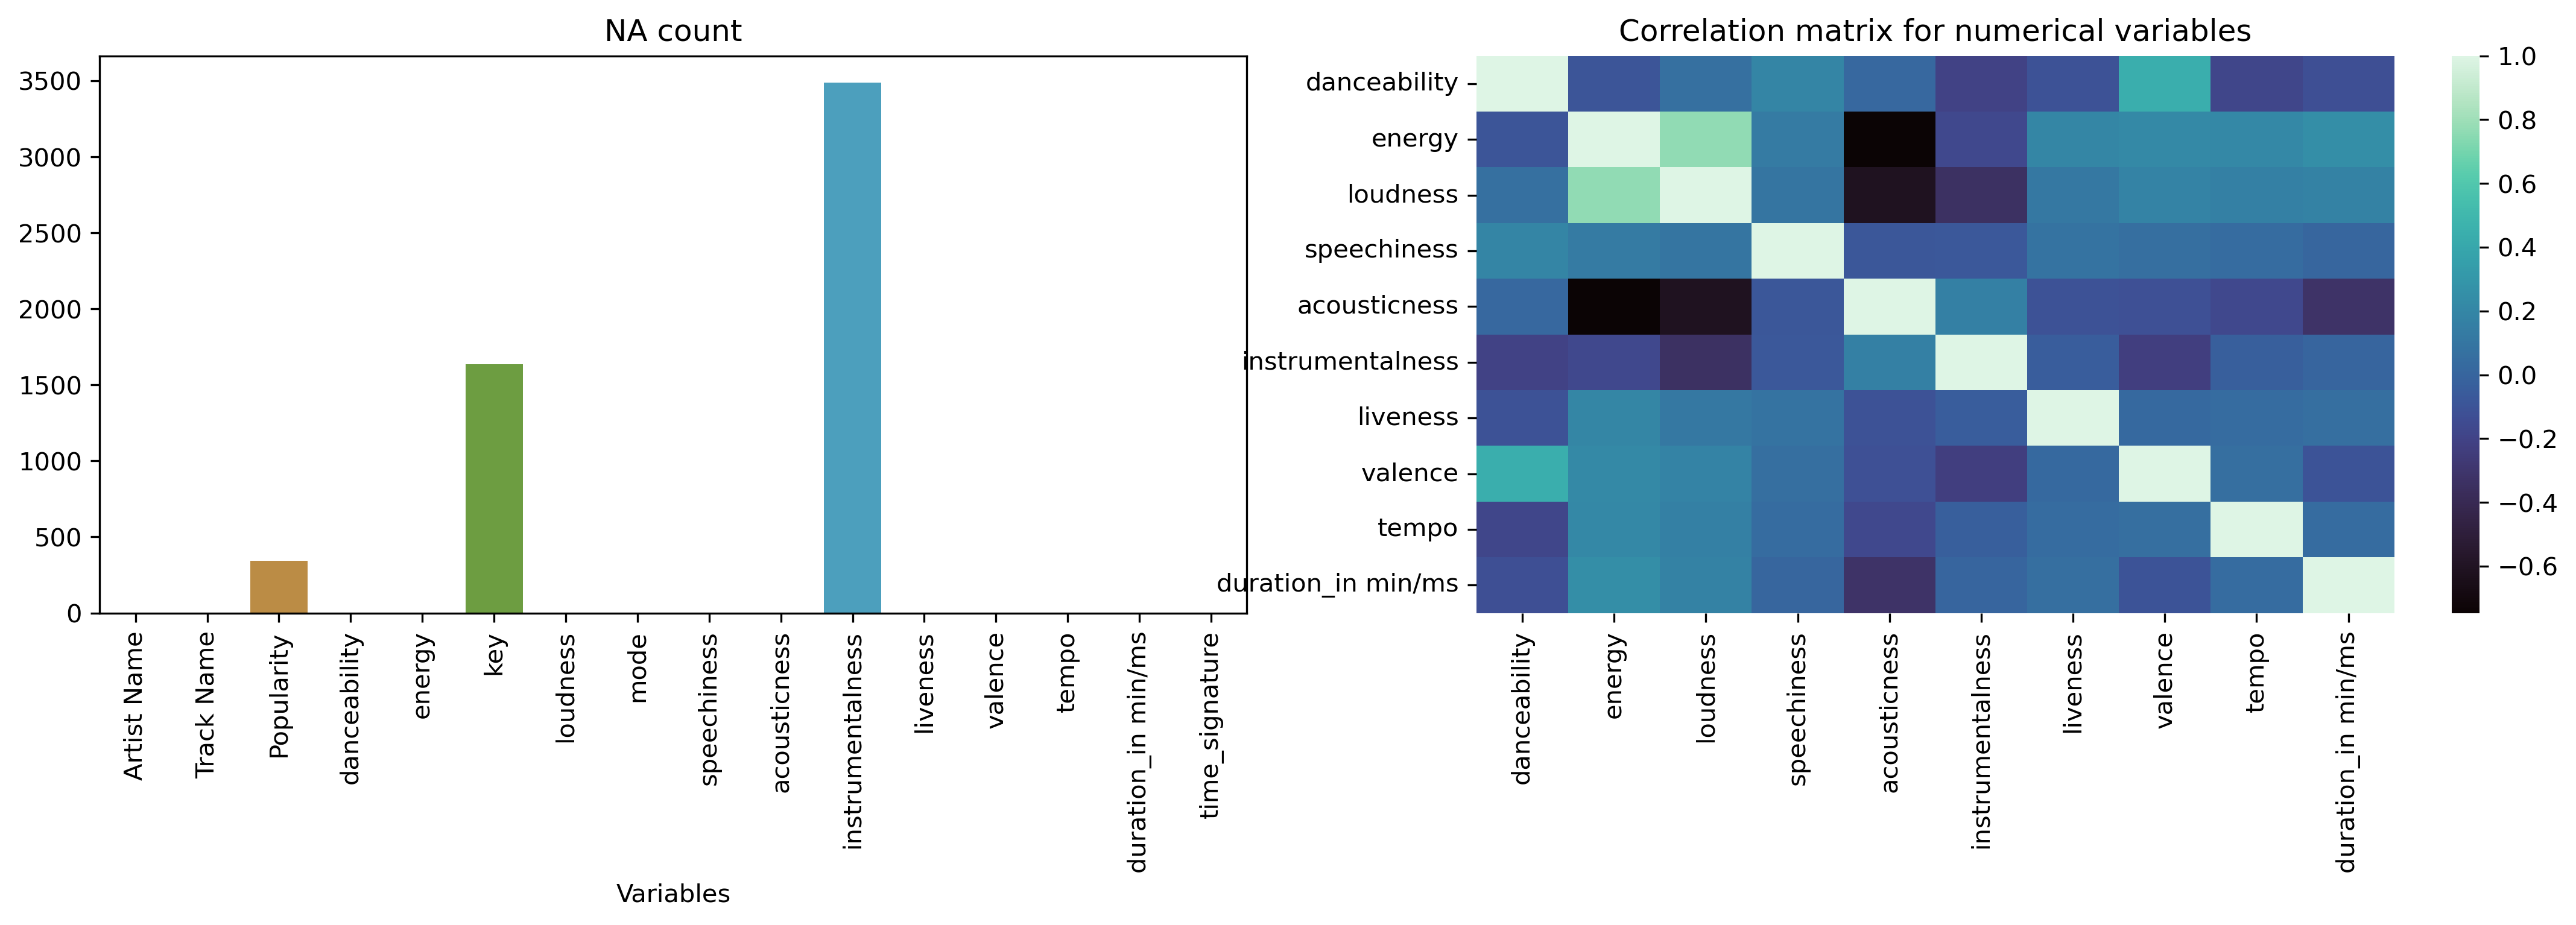

In [7]:
run_eda(X_train, factor_thershold=100)

Удалим признак `'Artist Name'` - один и тот же исполнитель может играть в нескольких жанрах. Также удалим `'Track Name'` и `'duration_in min/ms'` - оно содержит слишком много уникальных значений. Кроме того, вряд ли длительность композиции поможет нам определить её жанр.

In [29]:
X_train = X_train.drop(columns=['Artist Name', 'Track Name', 'duration_in min/ms'])

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Заполним `NA` медианным значением с помощью `SimpleImputer`. 

Также воспользуемся `OneHotEncoder` для кодировки кактегориальных признаков. Такими мы считаем 4: `'Popularity'`, `'key'`, `'mode'`, `'time_signature'` Значения признака `'mode'` и так представлены 0 и 1, поэтому его преобразовывать не будем. Признак `'Popularity'` также не будем преобразовывать - хотя он представлен рядом численных значений, между ними есть иерархия - чем выше значение, тем популярнее песня. 

#### `Pipeline`

In [30]:
cat_cols = ['key', 'time_signature']
imp_cols = ['Popularity', 'key', 'instrumentalness']

preprocessor = ColumnTransformer(transformers=[
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median'), imp_cols),
    ('ohe', OneHotEncoder(drop='first'), cat_cols)
])

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier())
])

param_grid = {
    'dtc__criterion': ['gini', 'entropy', 'log_loss'],
    'dtc__max_depth': list(range(1, 16)),
    'dtc__min_samples_leaf': [1, 2, 4],
    'dtc__min_samples_split': list(range(2, 6)),
    'dtc__class_weight': ['balanced', None]
}
search = GridSearchCV(dt_pipeline, param_grid, scoring='accuracy')
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

In [25]:
cat_cols = ['key', 'time_signature']
imp_cols = ['Popularity', 'key', 'instrumentalness']

preprocessor = ColumnTransformer(transformers=[
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median'), imp_cols),
    ('ohe', OneHotEncoder(drop='first'), cat_cols)
])

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(class_weight=None))
])

param_grid = {
    'dtc__criterion': ['gini', 'entropy', 'log_loss'],
    'dtc__max_depth': list(range(1, 16)),
    'dtc__min_samples_leaf': [1, 2, 4],
    'dtc__min_samples_split': list(range(2, 10)),
}
search = GridSearchCV(dt_pipeline, param_grid, scoring='accuracy')
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'dtc__criterion': 'gini', 'dtc__max_depth': 6, 'dtc__min_impurity_decrease': 0.0, 'dtc__min_samples_leaf': 4, 'dtc__min_samples_split': 4}
0.3142538641889545


### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.